In [1]:
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
import random
import json
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

d:\Software\anaconda3\envs\pytorch_gpu\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
d:\Software\anaconda3\envs\pytorch_gpu\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback y

In [2]:
# Step 1: Load a small subset (1000 samples) of the C4 dataset in English
dataset = load_dataset("c4", "en", split="train", streaming=True)

C:\Users\80528\.cache\huggingface\modules\datasets_modules\datasets\c4\584d57ebe81c209b6c7f31727066d2c4b4bba37cb7092cdd83083d5ec11207db\c4.py:53: FutureWarning: Dataset 'c4' is deprecated and will be deleted. Use 'allenai/c4' instead.
  warnings.warn(


In [14]:
small_dataset = [x["text"] for _, x in zip(range(10000), dataset) if "text" in x]

In [29]:
# Step 2: Initialize a sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient for semantic tasks

# Step 3: Compute embeddings for all sentences
embeddings = model.encode(small_dataset, show_progress_bar=True)

# Step 4: Calculate semantic differences
mean_embedding = np.mean(embeddings, axis=0)  # Average embedding for reference
semantic_differences = np.linalg.norm(embeddings - mean_embedding, axis=1)

# Step 5: Select top 10 samples with the largest semantic differences
top_indices = np.argsort(-semantic_differences)[:3]
top_samples = [small_dataset[i] for i in top_indices]

# Step 6: Write the top samples to a JSONL file
output_file = "3_samples.jsonl"
with open(output_file, "w") as f:
    for sample in top_samples:
        json.dump({"text": sample}, f)
        f.write("\n")  # JSONL format requires newline-separated JSON objects

print(f"Top samples have been stored in '{output_file}'.")

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Top samples have been stored in '3_samples.jsonl'.


In [4]:
# Step 2: Initialize a sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient for semantic tasks

# Step 3: Compute embeddings for all sentences
embeddings = model.encode(small_dataset, show_progress_bar=True)

# Step 4: Calculate semantic differences
mean_embedding = np.mean(embeddings, axis=0)  # Average embedding for reference
semantic_differences = np.linalg.norm(embeddings - mean_embedding, axis=1)

# Step 5: Select top 3 samples with the largest semantic differences
top_indices = np.argsort(-semantic_differences)[:100]
top_samples = [{"id": int(i), "text": small_dataset[i]} for i in top_indices]

# Step 6: Write the top samples with IDs to a JSONL file
output_file = "100_samples.jsonl"
with open(output_file, "w") as f:
    for sample in top_samples:
        json.dump(sample, f)
        f.write("\n")  # JSONL format requires newline-separated JSON objects

print(f"Top samples with IDs have been stored in '{output_file}'.")

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Top samples with IDs have been stored in '100_samples.jsonl'.


In [16]:
# Step 2: Initialize a sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 3: Compute embeddings for all sentences
embeddings = model.encode(small_dataset, show_progress_bar=True)

# Step 4: Apply K-Means clustering with 100 clusters
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans.fit(embeddings)

# Step 5: Find the representative text for each cluster
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

representative_samples = []
for cluster_idx in range(num_clusters):
    cluster_indices = np.where(labels == cluster_idx)[0]
    cluster_embeddings = embeddings[cluster_indices]
    cluster_texts = [small_dataset[idx] for idx in cluster_indices]
    
    # Find the point closest to the centroid
    distances_to_centroid = np.linalg.norm(cluster_embeddings - centroids[cluster_idx], axis=1)
    closest_idx = cluster_indices[np.argmin(distances_to_centroid)]
    representative_samples.append({
    "sample_id": int(closest_idx),  # Convert int64 to int
    "text": small_dataset[closest_idx]
})


# Step 6: Save the 100 representative samples to `100_samples.jsonl`
# Step 6: Save the 100 representative samples to `100_samples.jsonl`
with open('100_samples.jsonl', 'w') as f:
    for sample in representative_samples:
        f.write(json.dumps(sample) + '\n')


# Step 7: Find the 3 samples with the longest difference between each other
# Compute pairwise distances between cluster centroids
centroid_embeddings = np.array([embeddings[sample['sample_id']] for sample in representative_samples])
pairwise_distances = squareform(pdist(centroid_embeddings, metric='euclidean'))

# Find the 3 samples maximizing the sum of pairwise distances
best_indices = None
max_distance = -np.inf
num_representatives = len(representative_samples)

# Check all combinations of 3 samples
for i in range(num_representatives):
    for j in range(i + 1, num_representatives):
        for k in range(j + 1, num_representatives):
            distance_sum = (
                pairwise_distances[i, j] +
                pairwise_distances[j, k] +
                pairwise_distances[k, i]
            )
            if distance_sum > max_distance:
                max_distance = distance_sum
                best_indices = (i, j, k)

# Extract the 3 samples
selected_samples = [representative_samples[idx] for idx in best_indices]

# Step 8: Save the 3 most different samples to `3_samples.jsonl`
with open('3_samples.jsonl', 'w') as f:
    for sample in selected_samples:
        f.write(json.dumps(sample) + '\n')

print("100 representative samples saved to '100_samples.jsonl'")
print("3 most different samples saved to '3_samples.jsonl'")

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

d:\Software\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100 representative samples saved to '100_samples.jsonl'
3 most different samples saved to '3_samples.jsonl'


In [15]:
# Step 4: Apply K-Means clustering with 100 clusters
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans.fit(embeddings)

# Step 5: Find the representative text for each cluster
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

representative_samples = []
for cluster_idx in range(num_clusters):
    cluster_indices = np.where(labels == cluster_idx)[0]
    cluster_embeddings = embeddings[cluster_indices]
    cluster_texts = [small_dataset[idx] for idx in cluster_indices]
    
    # Find the point closest to the centroid
    distances_to_centroid = np.linalg.norm(cluster_embeddings - centroids[cluster_idx], axis=1)
    closest_idx = cluster_indices[np.argmin(distances_to_centroid)]
    representative_samples.append({
    "sample_id": int(closest_idx),  # Convert int64 to int
    "text": small_dataset[closest_idx]
})


# Step 6: Save the 100 representative samples to `100_samples.jsonl`
# Step 6: Save the 100 representative samples to `100_samples.jsonl`
with open('100_samples.jsonl', 'w') as f:
    for sample in representative_samples:
        f.write(json.dumps(sample) + '\n')


# Step 7: Find the 3 samples with the longest difference between each other
# Compute pairwise distances between cluster centroids
centroid_embeddings = np.array([embeddings[sample['sample_id']] for sample in representative_samples])
pairwise_distances = squareform(pdist(centroid_embeddings, metric='euclidean'))

# Find the 3 samples maximizing the sum of pairwise distances
best_indices = None
max_distance = -np.inf
num_representatives = len(representative_samples)

# Check all combinations of 3 samples
for i in range(num_representatives):
    for j in range(i + 1, num_representatives):
        for k in range(j + 1, num_representatives):
            distance_sum = (
                pairwise_distances[i, j] +
                pairwise_distances[j, k] +
                pairwise_distances[k, i]
            )
            if distance_sum > max_distance:
                max_distance = distance_sum
                best_indices = (i, j, k)

# Extract the 3 samples
selected_samples = [representative_samples[idx] for idx in best_indices]

# Step 8: Save the 3 most different samples to `3_samples.jsonl`
with open('3_samples.jsonl', 'w') as f:
    for sample in selected_samples:
        f.write(json.dumps(sample) + '\n')

print("100 representative samples saved to '100_samples.jsonl'")
print("3 most different samples saved to '3_samples.jsonl'")

d:\Software\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

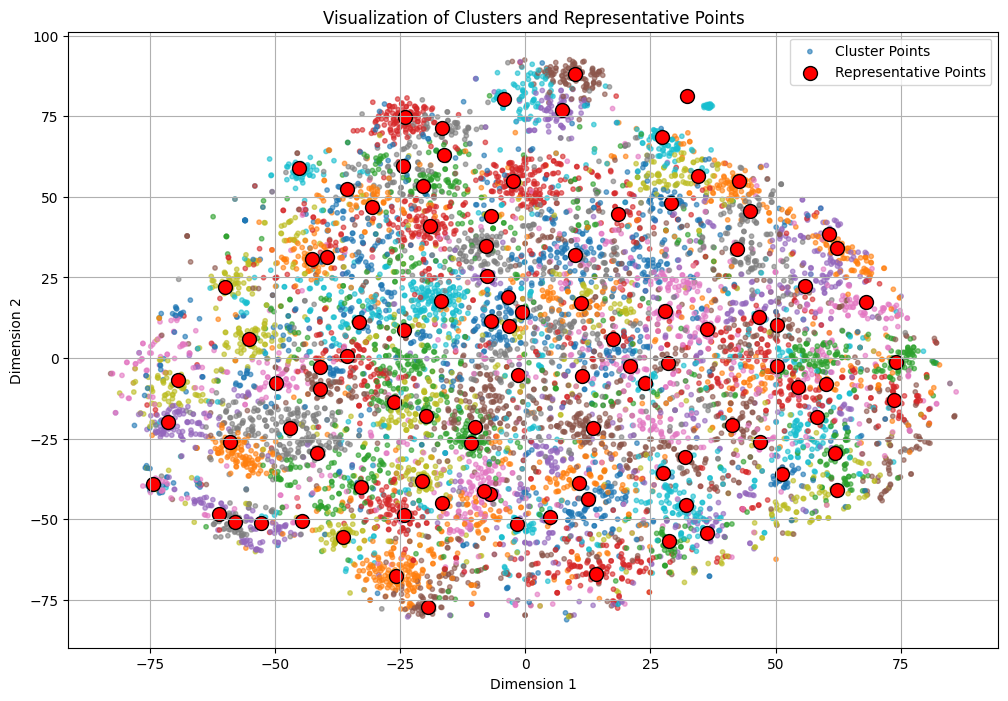

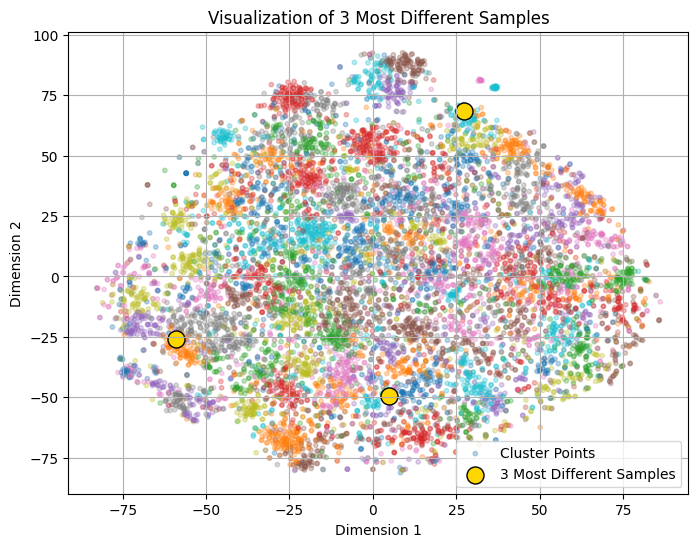

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Step 1: Dimensionality Reduction (using t-SNE or PCA)
# Here, we use t-SNE for better visualization
reduced_embeddings = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# Step 2: Extract cluster assignments and representative points
cluster_labels = kmeans.labels_
representative_indices = [sample['sample_id'] for sample in representative_samples]
representative_points = reduced_embeddings[representative_indices]

# Step 3: Plot the Clusters
plt.figure(figsize=(12, 8))

# Plot all points with cluster coloring
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=cluster_labels,
    cmap='tab10',  # Use a categorical colormap
    alpha=0.6,
    s=10,
    label='Cluster Points'
)

# Highlight the representative points
plt.scatter(
    representative_points[:, 0],
    representative_points[:, 1],
    c='red',
    s=100,
    edgecolor='black',
    label='Representative Points'
)

# Add legend and title
plt.legend()
plt.title('Visualization of Clusters and Representative Points')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

# Step 4: Highlight the 3 Most Different Samples
# Reduce the dimensionality of the selected 3 samples
selected_indices = [sample['sample_id'] for sample in selected_samples]
selected_points = reduced_embeddings[selected_indices]

# Plot the three most different samples
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=cluster_labels,
    cmap='tab10',
    alpha=0.3,
    s=10,
    label='Cluster Points'
)
plt.scatter(
    selected_points[:, 0],
    selected_points[:, 1],
    c='gold',
    s=150,
    edgecolor='black',
    label='3 Most Different Samples'
)

plt.legend()
plt.title('Visualization of 3 Most Different Samples')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()
